In [1]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image


from dataProcessing import train_loader

In [2]:
batch = next(iter(train_loader)) # loads one batch of training data

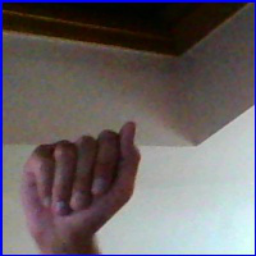

0


In [3]:
# displays the image and the label to make sure everything is working well

pil_image = transforms.ToPILImage()(batch[0][0])
display(pil_image)
print(batch[1][0].item()) # label of the image